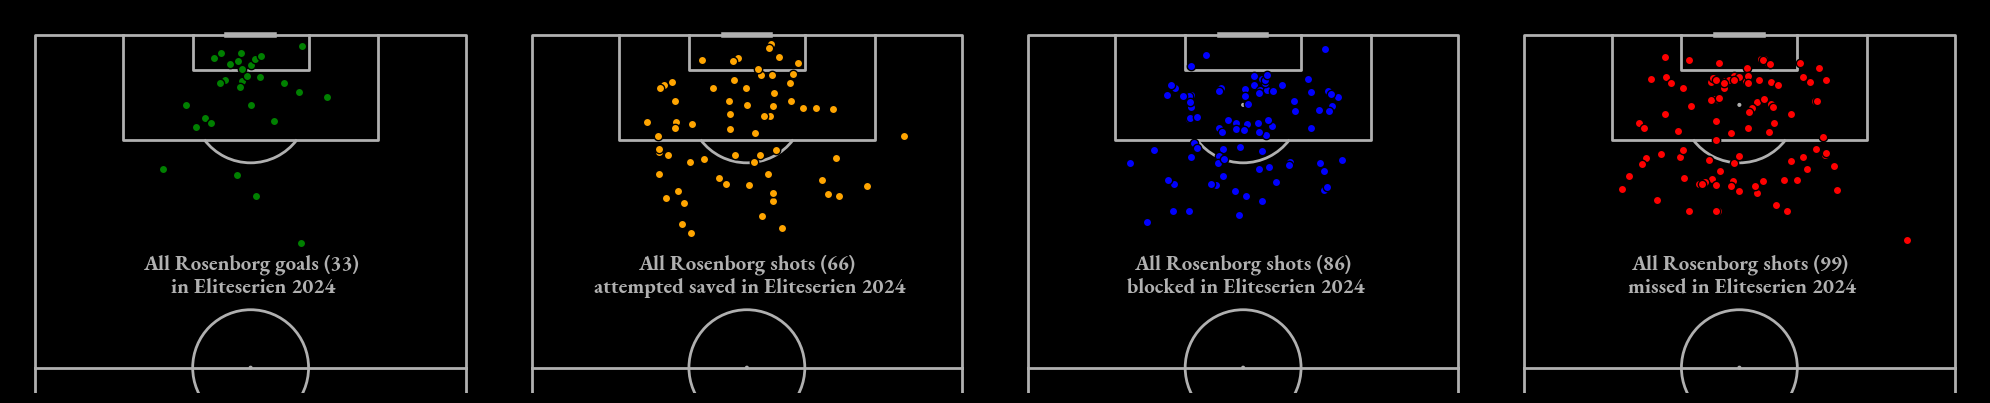

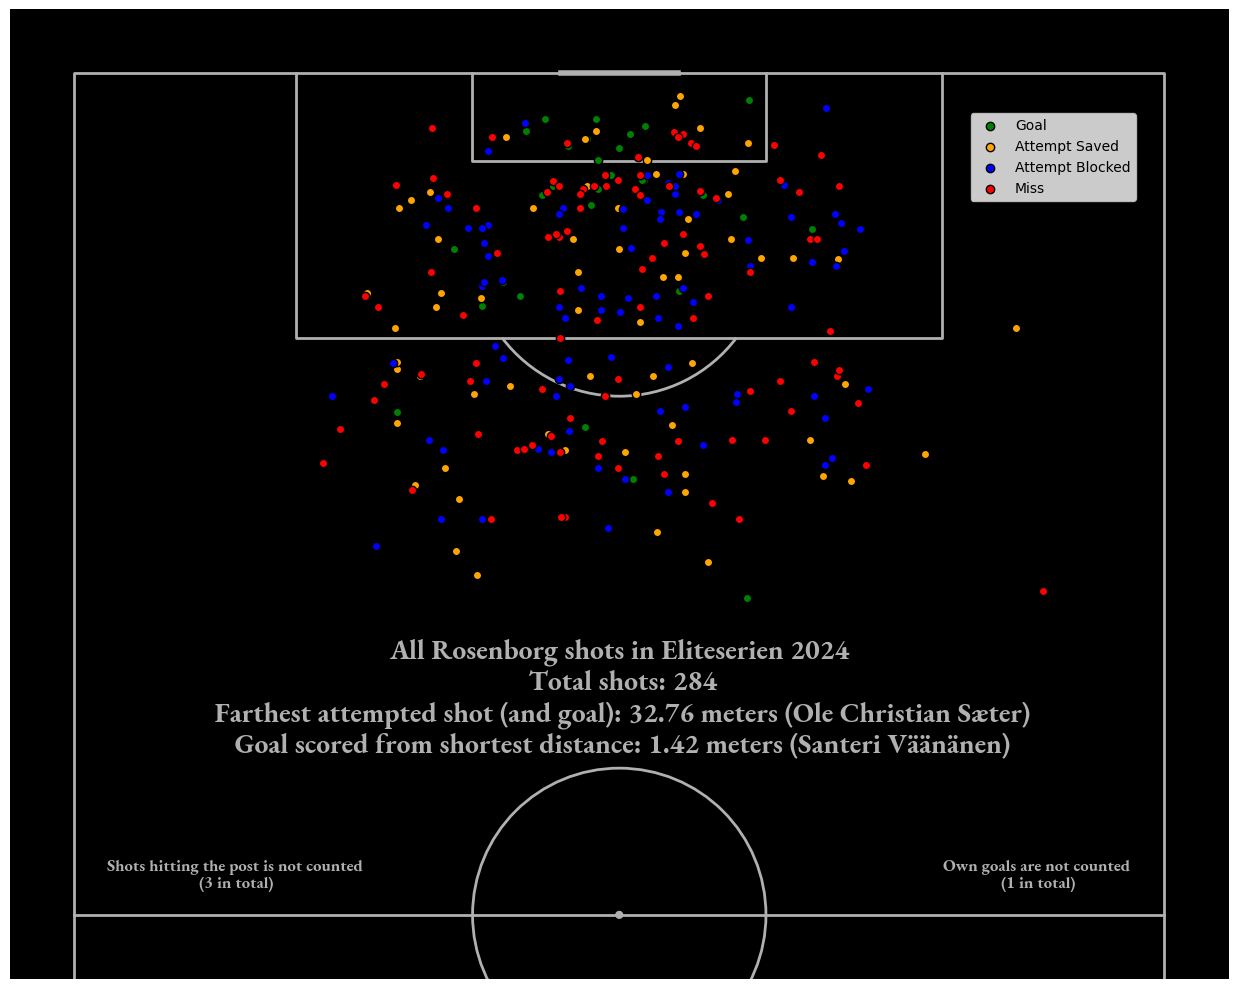

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pandas as pd
import requests
from matplotlib import font_manager
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen
import seaborn as sns
import json
from collections import Counter


url = "https://www.fotmob.com/teams/8422/fixtures/rosenborg?before=4385414"
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36"}


response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')
match_urls = [a['href'] for a in soup.find_all('a', href=True) if '/matches/' in a['href']]
match_ids = set(url.split('#')[-1] for url in match_urls if not url.split('#')[-1].startswith('44'))


''' SCRAPING SHOTMAP DATA FOR EACH MATCH'''
def scraper(match_id):
    params = {
    'matchId': match_id,
    }
    response = requests.get('https://www.fotmob.com/api/matchDetails', params=params, headers=headers)
    data = response.json()
    content = data.get('content', [])
    shotmap = content['shotmap']['Periods']['All']
    df = pd.DataFrame(shotmap)
    df['matchId'] = match_id
    return df

''' UNCOMMENT THIS LINE THE FIRST TIME YOU RUN THE SCRIPT
    COMMENT AGAIN WHEN YOU HAVE RAN IT ONCE, SO YOU DON'T HAVE TO SCRAPE THE DATA AGAIN
    THIS PART ADDS ALL THE SHOTMAP DATA TO A SINGLE DATAFRAME'''
# all_shots_rosenborg = pd.concat([scraper(match_id) for match_id in match_ids])


'''' 1. FILTER OUT ALL ROSENBORG SHOTS BY TEAMID.
     2. CORRECTING COORDINATES
     3. FILTERS ROSENBORG SHOTS BY GOAL, ATTEMPT SAVED AND MISS (SO WE CAN COLOR EACH DOT WITH A UNIQUE COLOR)'''
     
isowngoal = np.sum(all_shots_rosenborg['isOwnGoal'] == True)
rosenborg_team_id = all_shots_rosenborg[all_shots_rosenborg['teamId'] == 8422]
rosenborg_shots_goal = rosenborg_team_id[rosenborg_team_id['eventType'] == 'Goal']
rosenborg_shots_attempt_saved = rosenborg_team_id[(rosenborg_team_id['eventType'] == 'AttemptSaved') & (rosenborg_team_id['isBlocked'] == False)]
rosenborg_shots_miss = rosenborg_team_id[rosenborg_team_id['eventType'] == 'Miss']
rosenborg_shots_attempt_blocked = rosenborg_team_id[(rosenborg_team_id['eventType'] == 'AttemptSaved') & (rosenborg_team_id['isBlocked'] == True)]


''' REMOVES DUPLICATE MATCHES (HAPPENS WHEN A MATCH IS POSTPONED)'''
all_shots_rosenborg = rosenborg_team_id[(rosenborg_team_id['matchId'] != '4583736')]
rosenborg_shots_goal = rosenborg_shots_goal[(rosenborg_shots_goal['matchId'] != '4583736')]
rosenborg_shots_attempt_saved = rosenborg_shots_attempt_saved[(rosenborg_shots_attempt_saved['matchId'] != '4583736')]
rosenborg_shots_miss = rosenborg_shots_miss[(rosenborg_shots_miss['matchId'] != '4583736')]
rosenborg_shots_attempt_blocked = rosenborg_shots_attempt_blocked[(rosenborg_shots_attempt_blocked['matchId'] != '4583736')]


''' PITCH LENGTH AND WIDTH'''
pitch_length = 105
pitch_width = 68

font = font_manager.FontProperties(fname='C:\\Users\\Sander\\Downloads\\EB_Garamond\\static\\EBGaramond-Bold.ttf')


''' MISCELLANEOUS CALCULATIONS '''
rosenborg_team_id_index_reset = rosenborg_team_id.reset_index(drop=True)
total_shots = len(rosenborg_shots_goal) + len(rosenborg_shots_attempt_saved) + len(rosenborg_shots_miss) + len(rosenborg_shots_attempt_blocked)
longest_shot =  pitch_length - rosenborg_team_id['x'].min()
longest_shot_index = rosenborg_team_id_index_reset['x'].idxmin()
longest_shot_name = rosenborg_team_id_index_reset['playerName'][longest_shot_index]
shortest_shot = pitch_length - rosenborg_team_id['x'].max()
shortest_shot_index = rosenborg_team_id_index_reset['x'].idxmax()
shortest_shot__name = rosenborg_team_id_index_reset['playerName'][shortest_shot_index]
total_xg = rosenborg_shots_goal['expectedGoals'].sum()

''' PITCH '''
pitch = VerticalPitch(half=True, pitch_type='custom', pitch_length=pitch_length, pitch_width=pitch_width)
pitch2 = VerticalPitch(half=True, pitch_type='custom', pitch_length=pitch_length, pitch_width=pitch_width)

fig, axs = pitch.draw(ncols=4,figsize=(20, 15))
fig2, axs2 = pitch2.draw(figsize=(15,10))


fig.patch.set_facecolor('black')
for ax in axs:
    ax.set_facecolor('black')
''' PLOTTING SHOTS in 4 different subplots '''
pitch.scatter(rosenborg_shots_goal.x, rosenborg_shots_goal.y, color='green', edgecolors='black', zorder=12, label='Goal', ax=axs[0])
pitch.scatter(rosenborg_shots_attempt_saved.x, rosenborg_shots_attempt_saved.y, color='orange', edgecolors='black', zorder=12, label='Attempt Saved', ax=axs[1])
pitch.scatter(rosenborg_shots_attempt_blocked.x, rosenborg_shots_attempt_blocked.y, color='blue', edgecolors='black', zorder=12, label='Attempt Blocked', ax=axs[2])
pitch.scatter(rosenborg_shots_miss.x, rosenborg_shots_miss.y, color='red', edgecolors='black', zorder=12, label='Miss', ax=axs[3])

fig.patch.set_facecolor('black')
axs2.set_facecolor('black')
''' PLOTTING SHOTS in 1 subplot '''
pitch2.scatter(rosenborg_shots_goal.x, rosenborg_shots_goal.y, color='green', edgecolors='black', zorder=12, label='Goal', ax=axs2)
pitch2.scatter(rosenborg_shots_attempt_saved.x, rosenborg_shots_attempt_saved.y, color='orange', edgecolors='black', zorder=12, label='Attempt Saved', ax=axs2)
pitch2.scatter(rosenborg_shots_attempt_blocked.x, rosenborg_shots_attempt_blocked.y, color='blue', edgecolors='black', zorder=12, label='Attempt Blocked', ax=axs2)
pitch2.scatter(rosenborg_shots_miss.x, rosenborg_shots_miss.y, color='red', edgecolors='black', zorder=12, label='Miss', ax=axs2)
axs2.legend(loc='upper right', bbox_to_anchor=(0.93,0.9))

txt = axs[0].text(x=34, y=67, s=f'All Rosenborg goals ({len(rosenborg_shots_goal)})\n in Eliteserien 2024',size=15,fontproperties=font, color=pitch.line_color,va='center', ha='center')
txt = axs[1].text(x=34, y=67, s=f'All Rosenborg shots ({len(rosenborg_shots_attempt_saved)})\n attempted saved in Eliteserien 2024',size=15,fontproperties=font, color=pitch.line_color,va='center', ha='center')
txt = axs[2].text(x=34, y=67, s=f'All Rosenborg shots ({len(rosenborg_shots_attempt_blocked)})\n blocked in Eliteserien 2024',size=15,fontproperties=font, color=pitch.line_color,va='center', ha='center')
txt = axs[3].text(x=34, y=67, s=f'All Rosenborg shots ({len(rosenborg_shots_miss)})\n missed in Eliteserien 2024',size=15,fontproperties=font, color=pitch.line_color,va='center', ha='center')
txt = axs2.text(x=34, y=66,
                s=f'All Rosenborg shots in Eliteserien 2024\n Total shots: {total_shots}\n Farthest attempted shot (and goal): {longest_shot:.2f} meters ({longest_shot_name})\n Goal scored from shortest distance: {shortest_shot:.2f} meters ({shortest_shot__name})',
                size=20,fontproperties=font, color=pitch.line_color,va='center', ha='center')
txt = axs2.text(x=58, y=55,
                s=f'Shots hitting the post is not counted\n (3 in total)',
                size=12,fontproperties=font, color=pitch.line_color,va='center', ha='center')
txt = axs2.text(x=8, y=55,
                s=f'Own goals are not counted\n (1 in total)',
                size=12,fontproperties=font, color=pitch.line_color,va='center', ha='center')


